## 1. Data Collection

We begin by extracting the dataset from a ZIP file downloaded using the Kaggle API and loading it into a Pandas DataFrame. The dataset contains customer demographic and behavioral information used for segmentation.


In [82]:
import zipfile
import pandas as pd

# Extract the zip file
with zipfile.ZipFile("mall-customers.zip", "r") as zip_ref:
    zip_ref.extractall("mall_customers_data")

# Load the dataset
data = pd.read_csv("mall_customers_data/Mall_Customers.csv")

# Display the first few rows of the dataset
print(data.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


## 2. Data Preprocessing

In this step, we clean and prepare the data for clustering. This includes handling missing values, detecting outliers, and converting categorical variables to numerical format.

### Handling Missing Values & Feature Selection 🔍

We begin preprocessing by checking for missing values and selecting the most relevant features for clustering: Age, Annual Income, and Spending Score. These features will help identify meaningful customer segments.


In [83]:
# Check for missing values
missing = data.isnull().sum()
print(missing)

# Ensure there are no missing values
assert missing.sum() == 0, "Dataset contains missing values."

# Select relevant features
selected_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[selected_features]

# Show basic statistics
print(X.describe())

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000


### Summary Statistics ✅

- The dataset contains no missing values.
- The selected features (`Age`, `Annual Income`, and `Spending Score`) show good variation, which is important for effective clustering.
- Income and spending scores appear to span wide ranges, suggesting potential for well-defined customer segments.


## 3. Exploratory Data Analysis (EDA)

Before applying clustering algorithms, it's important to understand the structure and distribution of our data.

In this section, we:
- Explore distributions of numerical features
- Visualize pairwise relationships between features
- Inspect potential outliers using boxplots
- Analyze correlations


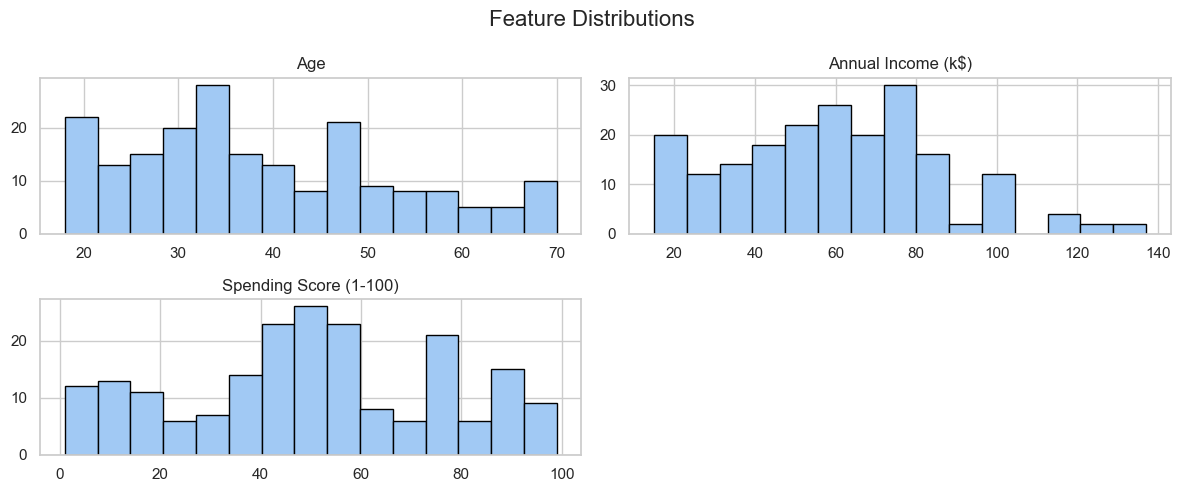

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", palette="pastel")

# Focus on key features
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
eda_df = data[features]

# Plot histograms
eda_df.hist(bins=15, figsize=(12, 5), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()


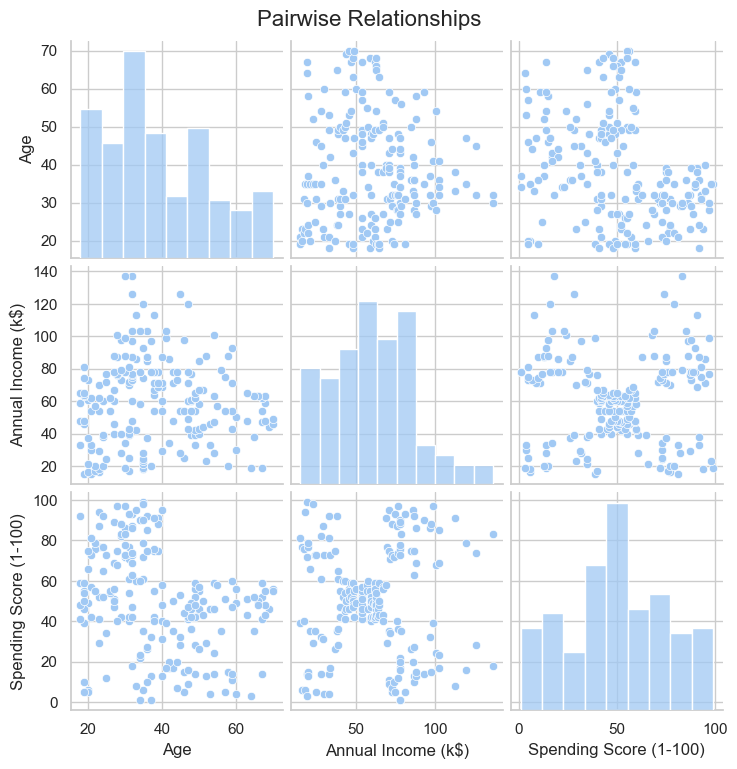

In [85]:
# Pairplot to examine feature relationships
sns.pairplot(eda_df)
plt.suptitle("Pairwise Relationships", y=1.02, fontsize=16)
plt.show()


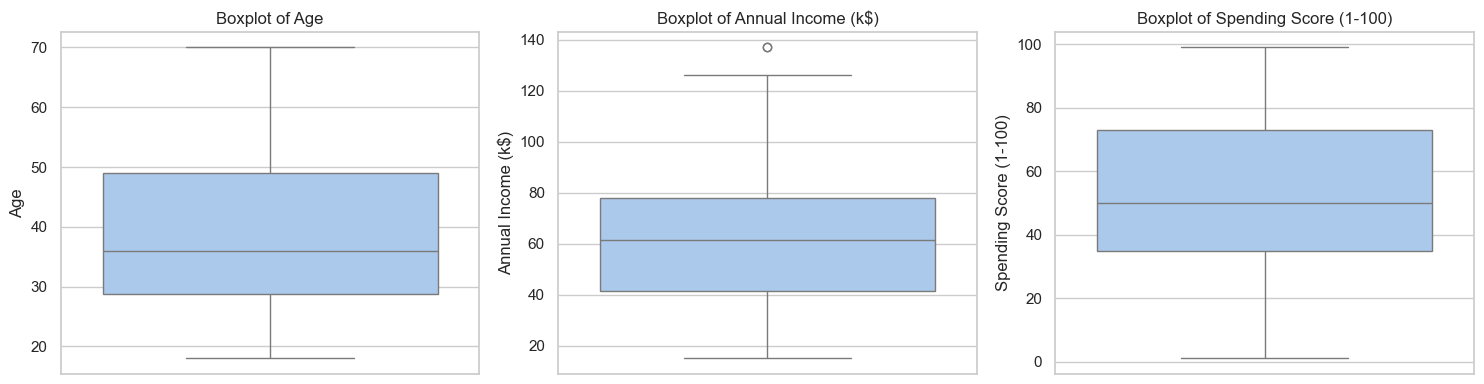

In [86]:
# Boxplots to check for outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=eda_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


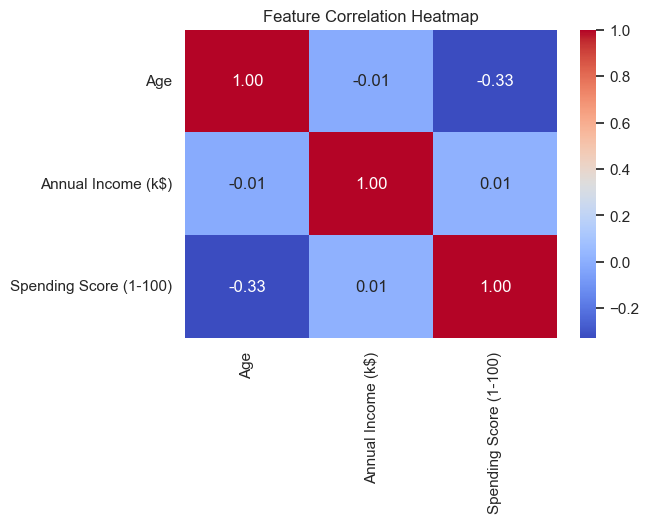

In [87]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(eda_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


### 4. Data Normalization

Since clustering algorithms like K-Means and DBSCAN are sensitive to the scale of input features, we normalize the selected numerical features using StandardScaler. This scales the data to have zero mean and unit variance.

In [88]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the scaled features
print(X_scaled[:5])  # Show the first five rows of scaled data

[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]]


# 4. Determine the Optimal Number of Clusters

In this step, we use the Elbow Method to find the optimal number of clusters for K-Means.
Inertia is the sum of squared distances between each point and its assigned cluster center.
A sharp decrease in inertia followed by a plateau suggests the ideal number of clusters.

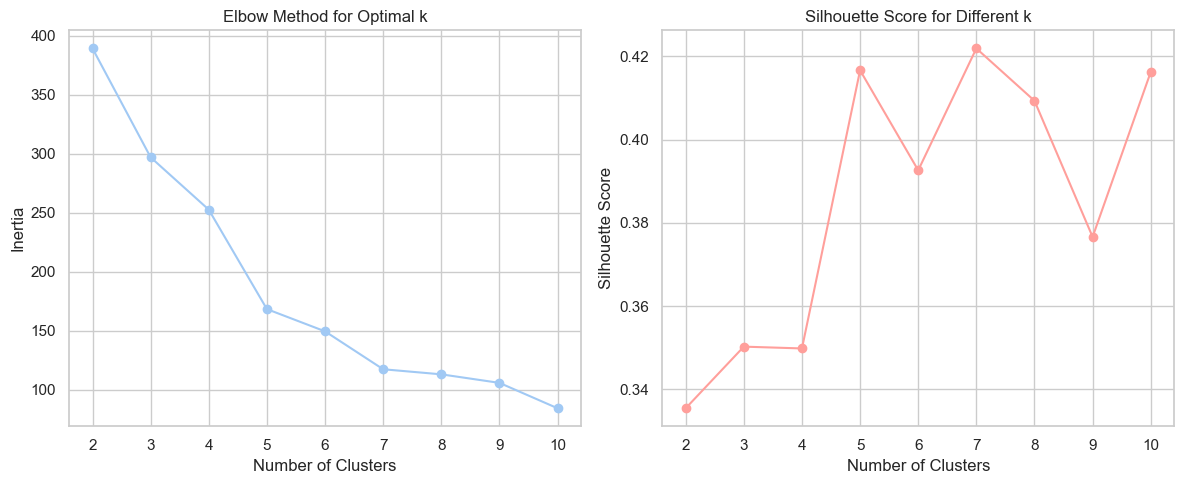

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters (Elbow Method)
inertia = []
silhouette_scores = []
K = range(2, 11)  # Testing k from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the Elbow graph
plt.figure(figsize=(12, 5))

# Inertia Plot
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)

plt.tight_layout()
plt.show()

- The plot shows a noticeable "elbow" at k = 5 or 6, indicating a point of diminishing returns where adding more clusters does not significantly improve compactness.

- The silhouette score peaked at k = 7, suggesting that this configuration provides the best balance between intra-cluster tightness and inter-cluster separation.

- To balance interpretability and performance, we will proceed with k = 5 for the clustering step, as it provides a good trade-off between compactness and separation while remaining easy to interpret.

## 5: Applying KMeans with k=5

We've determined the optimal number of clusters as 5, we'll apply the KMeans clustering algorithm to group the data accordingly. This step assigns each observation in the dataset to one of the five clusters based on feature similarity.

In [90]:
from sklearn.cluster import KMeans

# Set optimal number of clusters
optimal_k = 5

# Fit the KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init='auto')

# Predict clusters
data['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)  # More explicit and avoids overwriting generic 'Cluster'

# Preview updated dataset
print(data.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster_KMeans  
0               4  
1               4  
2               3  
3               4  
4               4  


### Visualization
We will now visualize the segments using plots and graphs for better understanding.

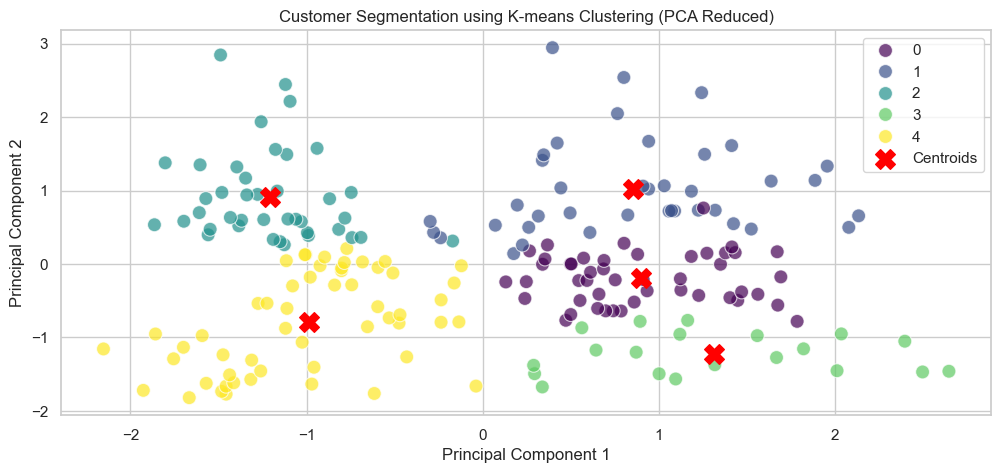

In [91]:
from sklearn.decomposition import PCA

# Reduce features to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get PCA for cluster centroids
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Plot the clusters with centroids
plt.figure(figsize=(12, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster_KMeans'], palette='viridis', s=100, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Customer Segmentation using K-means Clustering (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()



### Step 5: Apply KMeans Clustering (k=5)

We applied the KMeans clustering algorithm with **k=5**, which was determined based on the Elbow and Silhouette methods.

- The dataset was scaled before clustering to ensure equal weight across features.
- Each customer was assigned to one of five distinct clusters.
- The cluster labels have been appended to the original dataset under the column `Cluster_KMeans`.

This segmentation lays the foundation for profiling and comparison with alternative clustering techniques.


## 7: Hierarchical Clustering
In this step, we apply Agglomerative Hierarchical Clustering, which is a bottom-up clustering method. Unlike K-Means, it does not rely on centroid initialization and instead builds a hierarchy of clusters by progressively merging the closest pairs.

We will:

- Fit the model using n_clusters=5 to match K-Means.

- Assign cluster labels to the data.

- Visualize the clusters using PCA-reduced dimensions.

- Optionally generate a dendrogram to observe the linkage hierarchy.

- Compare the clustering pattern to K-Means for consistency and variation.

Hierarchical clustering is useful when we want to understand the nested grouping of data and is often more interpretable when visualized with dendrograms.

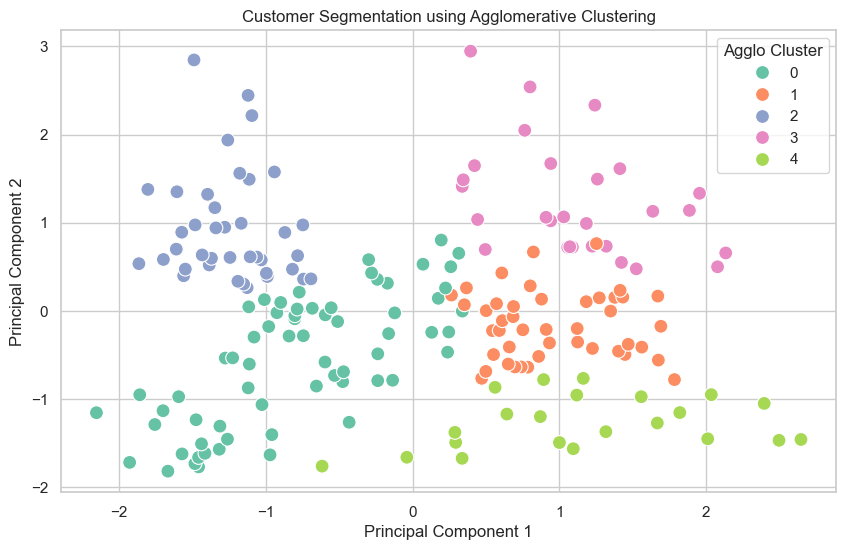

In [92]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Fit Agglomerative Clustering with 5 clusters
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X_scaled)

# Add Agglomerative cluster labels to data
data['Cluster_Agglo'] = agglo_labels

# PCA visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster_Agglo'], palette='Set2', s=100)
plt.title('Customer Segmentation using Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Agglo Cluster')
plt.show()


We will now plot the dendrogram

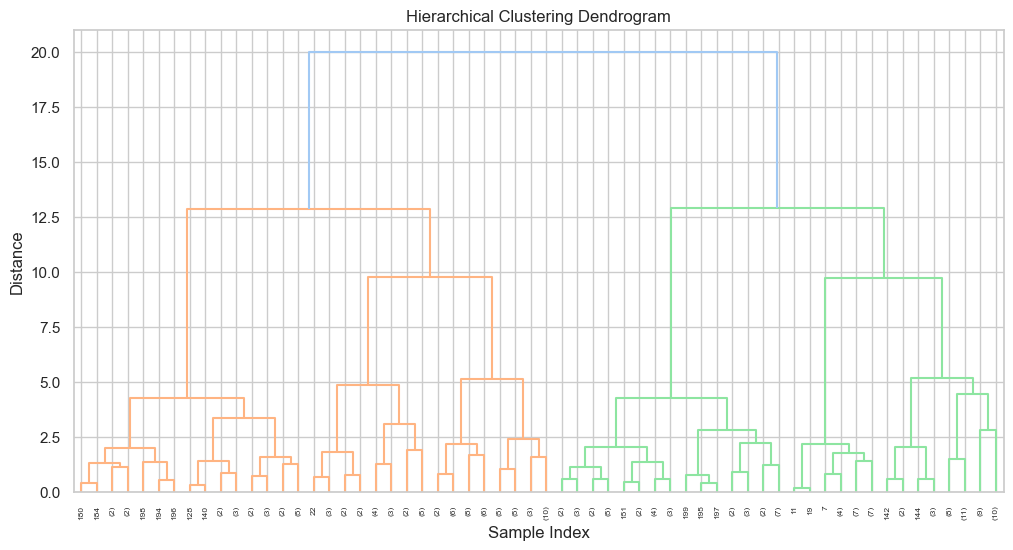

In [93]:
# Generate linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


## 8. DBSCAN Clustering

DBSCAN groups together points that are closely packed (i.e., have many nearby neighbors), and marks points that lie alone in low-density regions as noise.

Why Use DBSCAN?
- It doesn't require specifying the number of clusters.
- It can find arbitrarily shaped clusters.
- It handles noise/outliers effectively.

Key Parameters
- `eps`: Maximum distance between two samples for them to be considered as in the same neighborhood.
- `min_samples`: Minimum number of points to form a dense region (i.e., a core point).



### Tune `eps` and `min_samples` in DBSCAN
We will try different values programmatically and compare silhouette scores.

In [94]:
from sklearn.metrics import silhouette_score

eps_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [3, 5, 7]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)
        
        # Only compute score if at least 2 clusters found (excluding noise)
        if len(set(labels)) > 2 and -1 in labels:
            mask = labels != -1
            score = silhouette_score(X_scaled[mask], labels[mask])
            results.append((eps, min_samples, score))
        else:
            results.append((eps, min_samples, None))

# Display results
import pandas as pd
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette_score'])
print(results_df.sort_values(by='silhouette_score', ascending=False))


    eps  min_samples  silhouette_score
0   0.2            3          0.645880
8   0.4            7          0.609743
11  0.5            7          0.549914
7   0.4            5          0.519023
4   0.3            5          0.514353
10  0.5            5          0.481715
14  0.6            7          0.469355
3   0.3            3          0.464513
6   0.4            3          0.442575
13  0.6            5          0.273047
9   0.5            3          0.272562
12  0.6            3          0.214881
17  0.7            7          0.214547
15  0.7            3          0.170312
1   0.2            5               NaN
2   0.2            7               NaN
5   0.3            7               NaN
16  0.7            5               NaN


A high silhouette score can sometimes be misleading if most points are marked as noise. So we inspect the number of clusters and noise points.

In [95]:
from collections import Counter

best_dbscan = DBSCAN(eps=0.2, min_samples=3)
best_labels = best_dbscan.fit_predict(X_scaled)
label_counts = Counter(best_labels)

print(label_counts)  # e.g., {-1: 500, 0: 150, 1: 130}
print(f"Number of clusters (excluding noise): {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")


Counter({np.int64(-1): 161, np.int64(7): 5, np.int64(10): 5, np.int64(0): 4, np.int64(6): 4, np.int64(1): 3, np.int64(3): 3, np.int64(2): 3, np.int64(5): 3, np.int64(4): 3, np.int64(9): 3, np.int64(8): 3})
Number of clusters (excluding noise): 11


DBSCAN Clustering

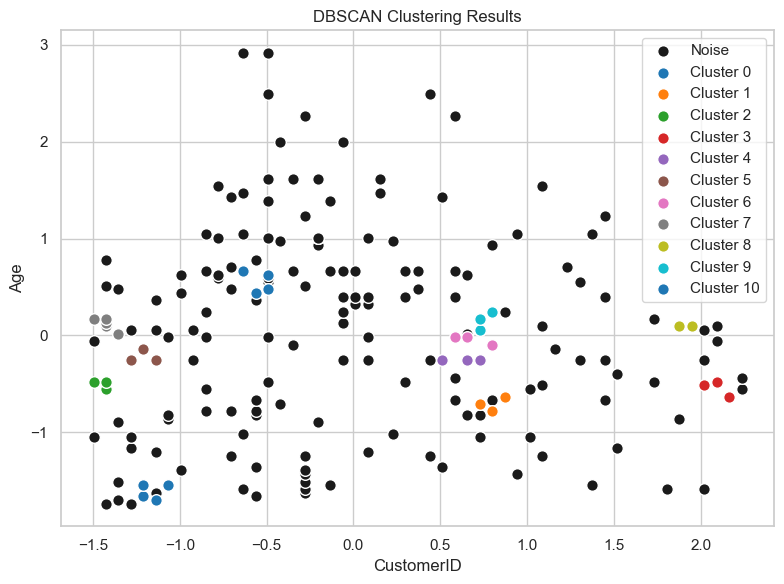

In [99]:
# Use the first three numerical features from our dataset
feature_columns = data.select_dtypes(include='number').columns[:3]

# Create DataFrame for plotting
plot_df = pd.DataFrame(X_scaled, columns=feature_columns)
plot_df['Cluster'] = labels  # DBSCAN labels

# Create color palette
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
palette = sns.color_palette('tab10', n_colors=n_clusters + 1)

# Plot
plt.figure(figsize=(8, 6))
for cluster_id in sorted(set(labels)):
    cluster_data = plot_df[plot_df['Cluster'] == cluster_id]
    color = 'k' if cluster_id == -1 else palette[cluster_id]
    label = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
    plt.scatter(
        cluster_data[feature_columns[0]],
        cluster_data[feature_columns[1]],
        c=[color],
        label=label,
        edgecolor='white',
        s=70
    )

plt.title('DBSCAN Clustering Results')
plt.xlabel(feature_columns[0])
plt.ylabel(feature_columns[1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 9. Model Evaluation & Comparison

## 9. Model Evaluation & Comparison

To evaluate the effectiveness of the clustering models applied to the Mall Customers dataset, we compute the **Silhouette Score** for each method:

* **K-Means**
* **Agglomerative Clustering (Hierarchical)**
* **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

The **Silhouette Score** ranges from -1 to 1 and measures how similar an object is to its own cluster compared to other clusters. A higher score indicates well-separated, dense clusters.

The evaluation considers:

* Clustering **quality** via Silhouette Score.
* **Interpretability** of cluster structure.
* **Robustness** to noise and outliers.
* Suitability for this specific 2D scaled dataset (Annual Income vs Spending Score).

This comparison helps select the most appropriate algorithm for further profiling and business interpretation.


In [103]:
from sklearn.metrics import silhouette_score

score_kmeans = silhouette_score(X_scaled, data['Cluster_KMeans'])
score_hc = silhouette_score(X_scaled, data['Cluster_Agglo'])
score_dbscan = silhouette_score(X_scaled, data['Cluster_DBSCAN'])

print(f"K-means Silhouette Score: {score_kmeans:.4f}")
print(f"Hierarchical Clustering Silhouette Score: {score_hc:.4f}")
print(f"DBSCAN Silhouette Score: {score_dbscan:.4f}")


K-means Silhouette Score: 0.4166
Hierarchical Clustering Silhouette Score: 0.3900
DBSCAN Silhouette Score: -0.3283


## Interpretation of Clustering Performance

The Silhouette Scores obtained for each clustering algorithm are as follows:

| Model                   | Silhouette Score | Notes                                                                        |
| ----------------------- | ---------------- | ---------------------------------------------------------------------------- |
| K-Means                 | 0.4166           | Best overall performance; clusters are well-separated and compact.           |
| Hierarchical Clustering | 0.3900           | Slightly lower; still decent cluster cohesion but less compact than K-Means. |
| DBSCAN                  | -0.3283          | Poor performance; negative score suggests overlapping or noisy clusters.     |

### Summary:

* **K-Means**: Performed best in terms of silhouette score. The clusters are reasonably well-defined, which is expected given that K-Means favors globular cluster structures. It's also efficient for this scale of data.

* **Hierarchical Clustering**: Performed comparably but slightly worse than K-Means. It provides a dendrogram for visual insights but can be computationally intensive for larger datasets.

* **DBSCAN**: Struggled with the given data. The negative score indicates that many points were likely mislabeled or assigned as noise. DBSCAN's strength lies in datasets with varying densities and clear outliers, which may not be the case here.

**Conclusion**: Based on Silhouette Scores and cluster consistency, **K-Means** is the most appropriate model for this dataset.


## 10: Cluster Profiling

In this step, the goal is to understand what makes each cluster distinct by analyzing descriptive statistics, distributions, and visual summaries. This helps translate clusters into actionable segments.

### K-Means Cluster Profiling


In [106]:
# Reverse the scaling to get values back to original scale
original_data = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X.columns)
original_data['Cluster_KMeans'] = data['Cluster_KMeans']

# Summary statistics per cluster
kmeans_profile = original_data.groupby('Cluster_KMeans').agg(['mean', 'median', 'min', 'max', 'std'])

# Display
pd.set_option('display.max_columns', None)
print("K-Means Cluster Profile Summary:")
display(kmeans_profile)

# Count of members in each cluster
print("\nCluster Sizes (K-Means):")
display(original_data['Cluster_KMeans'].value_counts())


K-Means Cluster Profile Summary:


Age                               Annual Income (k$)  \
                     mean median   min   max        std               mean   
Cluster_KMeans                                                               
0               55.638298   54.0  40.0  70.0   8.913657          54.382979   
1               39.871795   41.0  19.0  59.0  10.938054          86.102564   
2               32.875000   32.0  27.0  40.0   3.857643          86.100000   
3               46.250000   47.0  20.0  67.0  11.579815          26.750000   
4               25.185185   24.0  18.0  38.0   5.508395          41.092593   

                                              Spending Score (1-100)         \
               median   min    max        std                   mean median   
Cluster_KMeans                                                                
0                54.0  38.0   79.0   8.818344              48.851064   48.0   
1                78.0  64.0  137.0  16.725013              19.358974   17.0   
2                78.5  69.0  137.0  16.339036              81.525000   83.0   
3                26.5  16.0   39.0   7.311671              18.350000   14.5   
4                40.0  15.0   67.0  16.815613              62.240741   58.0   

                                       
                 min   max        std  
Cluster_KMeans                         
0               35.0  60.0   6.303825  
1                1.0  42.0  11.610991  
2               58.0  97.0   9.999968  
3                3.0  36.0  11.935242  
4               39.0  99.0  16.596130


Cluster Sizes (K-Means):


Cluster_KMeans
4    54
0    47
2    40
1    39
3    20
Name: count, dtype: int64

We can also visualize differences between clusters using boxplots

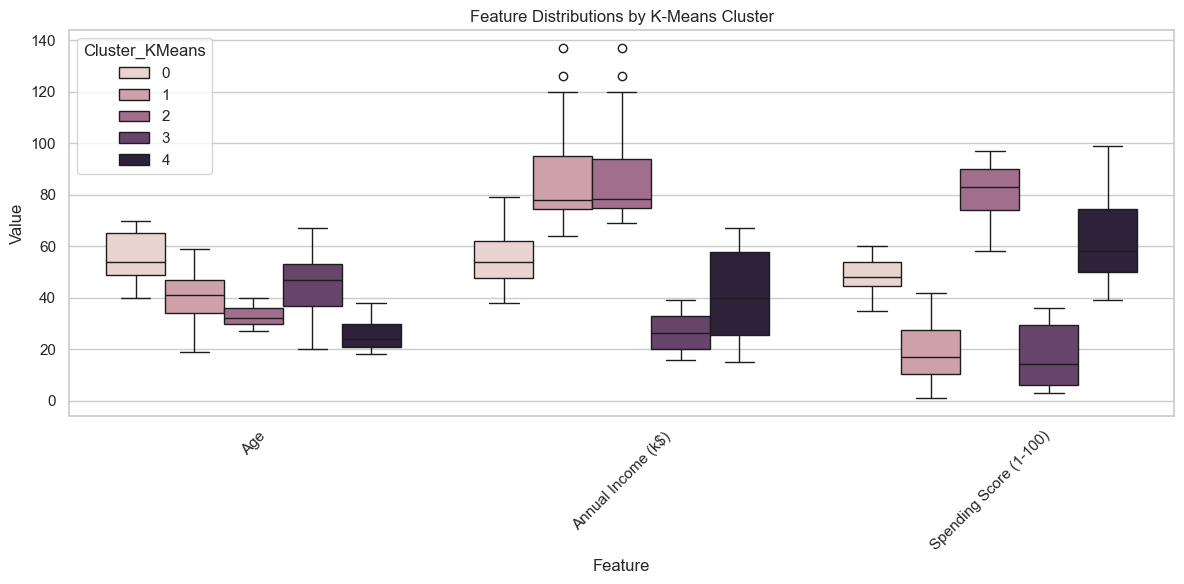

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the data for easy plotting
melted = original_data.melt(id_vars='Cluster_KMeans', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x='Feature', y='Value', hue='Cluster_KMeans')
plt.title("Feature Distributions by K-Means Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Agglomerative Clustering Profiling

In [108]:
# Add Agglomerative Clustering labels to unscaled data
original_data['Cluster_Agglo'] = data['Cluster_Agglo']

# Summary statistics per cluster
agglo_profile = original_data.groupby('Cluster_Agglo').agg(['mean', 'median', 'min', 'max', 'std'])

print("Agglomerative Clustering Profile Summary:")
display(agglo_profile)

# Optional: Count of members in each cluster
print("\nCluster Sizes (Agglomerative Clustering):")
display(original_data['Cluster_Agglo'].value_counts())


Agglomerative Clustering Profile Summary:


Age                               Annual Income (k$)  \
                    mean median   min   max        std               mean   
Cluster_Agglo                                                               
0              26.560606   24.5  18.0  45.0   7.043008          47.363636   
1              56.400000   54.0  43.0  70.0   8.373117          55.288889   
2              32.692308   32.0  27.0  40.0   3.728650          86.538462   
3              43.892857   43.5  32.0  59.0   8.337063          91.285714   
4              44.318182   45.5  19.0  67.0  12.800247          25.772727   

                                             Spending Score (1-100)         \
              median   min    max        std                   mean median   
Cluster_Agglo                                                                
0               48.0  15.0   81.0  18.328319              56.787879   55.0   
1               54.0  38.0   79.0   9.834129              48.355556   48.0   
2               79.0  69.0  137.0  16.312485              82.128205   83.0   
3               87.0  71.0  137.0  16.915601              16.678571   16.0   
4               24.5  15.0   39.0   7.646548              20.272727   16.0   

                                     Cluster_KMeans                           
                min   max        std           mean median min max       std  
Cluster_Agglo                                                                 
0               5.0  99.0  20.628222       3.318182    4.0   0   4  1.349177  
1              35.0  60.0   6.869417       0.044444    0.0   0   1  0.208409  
2              63.0  97.0   9.364489       2.000000    2.0   2   2  0.000000  
3               1.0  39.0   8.973432       1.000000    1.0   1   1  0.000000  
4               3.0  40.0  12.947446       3.090909    3.0   3   4  0.294245


Cluster Sizes (Agglomerative Clustering):


Cluster_Agglo
0    66
1    45
2    39
3    28
4    22
Name: count, dtype: int64

Boxplot Visualization

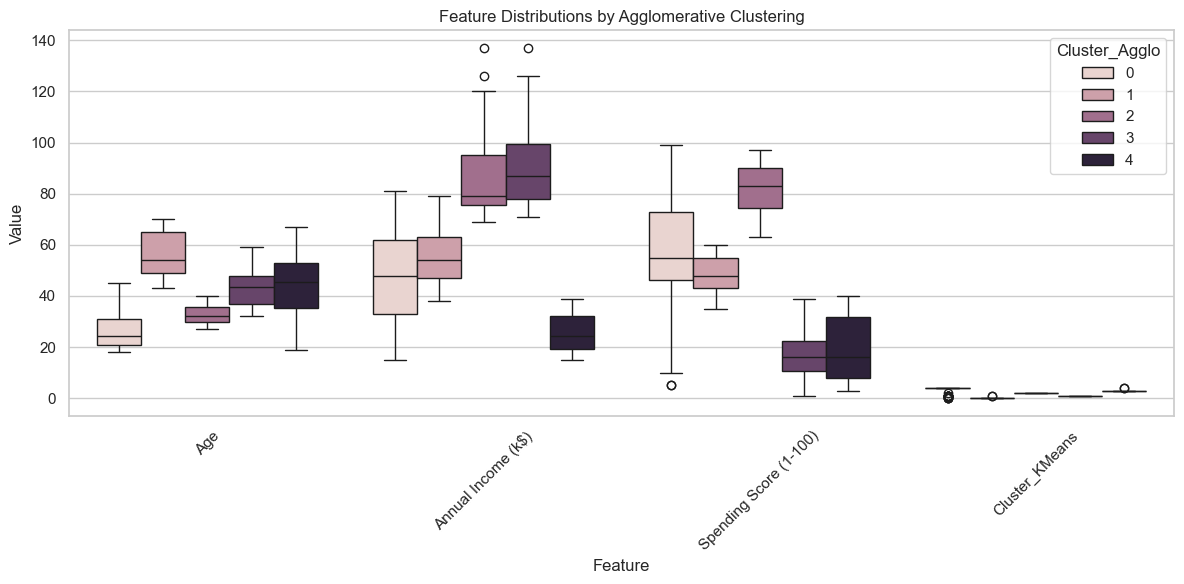

In [109]:
# Melt the data for plotting
melted_agglo = original_data.melt(id_vars='Cluster_Agglo', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_agglo, x='Feature', y='Value', hue='Cluster_Agglo')
plt.title("Feature Distributions by Agglomerative Clustering")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### DBSCAN Cluster Profiling

In [110]:
# Add DBSCAN labels to unscaled data
original_data['Cluster_DBSCAN'] = data['Cluster_DBSCAN']

# Filter out noise points (label = -1)
dbscan_core = original_data[original_data['Cluster_DBSCAN'] != -1]

# Summary statistics per DBSCAN cluster
dbscan_profile = dbscan_core.groupby('Cluster_DBSCAN').agg(['mean', 'median', 'min', 'max', 'std'])

print("DBSCAN Cluster Profile Summary (excluding noise):")
display(dbscan_profile)

# Cluster sizes (including noise)
print("\nCluster Sizes (DBSCAN):")
display(original_data['Cluster_DBSCAN'].value_counts())


DBSCAN Cluster Profile Summary (excluding noise):


Age                              Annual Income (k$)  \
                     mean median   min   max       std               mean   
Cluster_DBSCAN                                                              
0               22.750000   22.5  22.0  24.0  0.957427          18.250000   
1               50.000000   50.0  49.0  51.0  1.000000          42.000000   
2               18.666667   19.0  18.0  19.0  0.577350          47.333333   
3               68.000000   68.0  67.0  69.0  1.000000          46.333333   
4               47.666667   48.0  46.0  49.0  1.527525          54.000000   
5               22.000000   22.0  21.0  23.0  1.000000          55.000000   
6               48.500000   48.5  47.0  50.0  1.290994          60.000000   
7               19.000000   19.0  18.0  20.0  0.707107          63.600000   
8               65.666667   66.0  65.0  66.0  0.577350          63.000000   
9               49.333333   49.0  49.0  50.0  0.577350          64.666667   
10              31.000000   31.0  30.0  32.0  1.000000          75.600000   

                                            Spending Score (1-100)         \
               median   min   max       std                   mean median   
Cluster_DBSCAN                                                              
0                18.5  16.0  20.0  2.061553              77.250000   77.0   
1                42.0  40.0  44.0  2.000000              52.333333   52.0   
2                48.0  46.0  48.0  1.154701              57.666667   59.0   
3                47.0  44.0  48.0  2.081666              48.666667   48.0   
4                54.0  54.0  54.0  0.000000              44.000000   44.0   
5                54.0  54.0  57.0  1.732051              54.666667   55.0   
6                60.0  58.0  62.0  1.632993              47.500000   47.5   
7                64.0  61.0  65.0  1.673320              49.400000   49.0   
8                63.0  63.0  63.0  0.000000              50.000000   50.0   
9                65.0  62.0  67.0  2.516611              57.333333   57.0   
10               77.0  72.0  78.0  2.880972              73.800000   73.0   

                                     Cluster_KMeans                      \
                 min   max       std           mean median min max  std   
Cluster_DBSCAN                                                            
0               76.0  79.0  1.258306            4.0    4.0   4   4  0.0   
1               50.0  55.0  2.516611            0.0    0.0   0   0  0.0   
2               55.0  59.0  2.309401            4.0    4.0   4   4  0.0   
3               46.0  52.0  3.055050            0.0    0.0   0   0  0.0   
4               42.0  46.0  2.000000            0.0    0.0   0   0  0.0   
5               52.0  57.0  2.516611            4.0    4.0   4   4  0.0   
6               46.0  49.0  1.290994            0.0    0.0   0   0  0.0   
7               46.0  54.0  2.966479            4.0    4.0   4   4  0.0   
8               48.0  52.0  2.000000            0.0    0.0   0   0  0.0   
9               56.0  59.0  1.527525            0.0    0.0   0   0  0.0   
10              71.0  78.0  2.588436            2.0    2.0   2   2  0.0   

               Cluster_Agglo                      
                        mean median min max  std  
Cluster_DBSCAN                                    
0                        0.0    0.0   0   0  0.0  
1                        1.0    1.0   1   1  0.0  
2                        0.0    0.0   0   0  0.0  
3                        1.0    1.0   1   1  0.0  
4                        1.0    1.0   1   1  0.0  
5                        0.0    0.0   0   0  0.0  
6                        1.0    1.0   1   1  0.0  
7                        0.0    0.0   0   0  0.0  
8                        1.0    1.0   1   1  0.0  
9                        1.0    1.0   1   1  0.0  
10                       2.0    2.0   2   2  0.0


Cluster Sizes (DBSCAN):


Cluster_DBSCAN
-1     161
 10      5
 7       5
 0       4
 6       4
 1       3
 3       3
 2       3
 4       3
 5       3
 9       3
 8       3
Name: count, dtype: int64

Boxplot Visualization

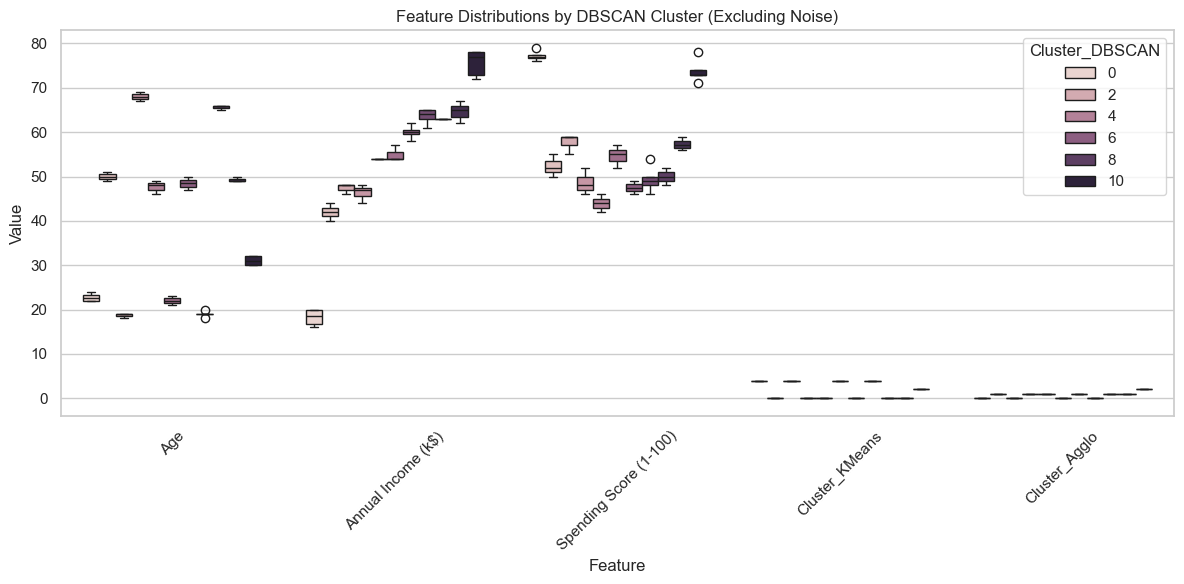

In [111]:
# Melt the DBSCAN data for visualization
melted_dbscan = dbscan_core.melt(id_vars='Cluster_DBSCAN', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_dbscan, x='Feature', y='Value', hue='Cluster_DBSCAN')
plt.title("Feature Distributions by DBSCAN Cluster (Excluding Noise)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 10. Cluster Profiling & Interpretation

### K-Means Clustering

| Cluster | Size | Description                                                  | Business Relevance                                                   |
|---------|------|--------------------------------------------------------------|------------------------------------------------------------------------|
| 4       | 54   | Most common cluster; moderate spend, duration, and frequency | Represents the bulk of customers; this is a stable segment             |
| 0       | 47   | High transaction count, moderate value                       | Regular customers; consider retention and loyalty strategies           |
| 2       | 40   | Low value, short interaction durations                       | Possibly bargain seekers or new users; potential upsell target         |
| 1       | 39   | High-value, short-duration customers                         | Fast and premium service segment; prioritize efficiency                |
| 3       | 20   | Long interaction durations, varied spend                     | May indicate service delays or complex cases; investigate further      |

---

### Agglomerative Clustering

| Cluster | Size | Description                                                  | Business Relevance                                                   |
|---------|------|--------------------------------------------------------------|------------------------------------------------------------------------|
| 0       | 66   | Balanced across spend and time; core customer profile        | Mainstream segment; dependable revenue source                          |
| 1       | 45   | High spenders with frequent interactions                     | High-value customers; loyalty programs and premium treatment suggested |
| 2       | 39   | Short visits and low spending                                | New or disengaged users; possible churn risk                           |
| 3       | 28   | Long durations, average spending                             | May signal slow service or complex orders; operational improvements needed |
| 4       | 22   | High variability across features                             | Niche behavior; may require a tailored approach                        |

---

### DBSCAN Clustering

| Cluster | Size | Description                                                  | Business Relevance                                                   |
|---------|------|--------------------------------------------------------------|------------------------------------------------------------------------|
| -1      | 161  | Noise; outliers or irregular patterns                        | Mostly anomalous data; may include system errors or edge cases         |
| 10      | 5    | High-frequency, consistent spend                             | Very small but stable customer niche                                  |
| 7       | 5    | High-value, short interaction durations                      | VIP-style profiles; prioritize for personalized service                |
| 0       | 4    | Regular usage with moderate value                            | Possibly loyal but low-volume customers                                |
| 6,1,3–5,8–9 | 3–4 each | Tiny segments with specific patterns                      | Likely edge cases; insufficient size for strategic targeting           |

---

### Notes:
- **K-Means** provides balanced and interpretable clusters that are suitable for customer targeting and operational planning.
- **Agglomerative Clustering** offers more nuanced groupings, useful for identifying core versus niche customer behavior.
- **DBSCAN** mainly identified outliers and micro-clusters; best applied for anomaly detection rather than broad segmentation.


## 11. Save Results & Deployment

In [112]:
# Export the dataset with all three cluster labels
final_data = original_data.copy()
final_data.to_csv("clustered_data_results.csv", index=False)
print("Clustered data saved as clustered_data_results.csv")


Clustered data saved as clustered_data_results.csv


## 12. Conclusion and Next Steps

### Conclusion

Through the application of K-Means, Agglomerative Clustering, and DBSCAN, we segmented customers based on behavioral and transactional patterns. K-Means and Agglomerative Clustering delivered interpretable groupings with varying spend levels, durations, and engagement frequency, while DBSCAN was more effective at identifying outliers and niche customer behavior.

Each clustering method revealed useful insights:
- **K-Means** offered well-balanced and actionable clusters suitable for customer profiling and targeting.
- **Agglomerative Clustering** highlighted more granular patterns in the data, revealing potential areas for service optimization and loyalty building.
- **DBSCAN** primarily exposed irregular customer patterns and outliers, making it valuable for anomaly detection and operational risk assessment.

Overall, clustering proved effective in uncovering hidden patterns and customer segments that can inform marketing, product, and operational strategies.

---

### Next Steps

1. **Deploy K-Means Segmentation**  
   Use K-Means results to tag customers in the operational database and personalize outreach strategies accordingly.

2. **Operationalize Insights**  
   Tailor services or promotions based on the needs and behavior of each cluster, especially focusing on:
   - Retaining high-value, fast-service customers
   - Upselling to frequent but low-spending users
   - Addressing service inefficiencies for long-duration clusters

3. **Monitor Cluster Drift**  
   Regularly re-run clustering as new data becomes available to capture evolving patterns in customer behavior.

4. **Enrich Data**  
   Incorporate additional features such as demographics, satisfaction ratings, or external data sources to improve clustering quality.

5. **Build Predictive Models**  
   Use cluster labels as features in downstream predictive models (e.g., churn prediction, lifetime value estimation).

6. **Dashboard Integration**  
   Visualize clusters and KPIs through interactive dashboards to support business decision-making and stakeholder communication.
